# Table of Content

## 1) Load Trajectory
## 2) Psuedocode for Data Collection
## 3) Default custom scene
## 4) Random Camera Angles
## 5) Load random X, Y positions
## 6) Counterfactual Objects
## 7) Different trajectories / tasks




## extra) Evaluation functions

#### removed) --- "move forward" / "move backward" configuations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from mani_skill2.utils.sapien_utils import look_at
import numpy as np
from utils import load_pickcube_v1, get_poses_from_instructions
import h5py, json
from mani_skill2.utils.io_utils import load_json
from skimage import io, color, filters
from transforms3d.euler import euler2quat

from sapien.core import Pose

from IPython.display import clear_output

# 1) Load trajectory

In [2]:
def load_h5_data(data):
    out = dict()
    for k in data.keys():
        if isinstance(data[k], h5py.Dataset):
            out[k] = data[k][:]
        else:
            out[k] = load_h5_data(data[k])
    return out

# env_id = "PickSingleYCB-v0"
env_id = "PickCube-v0"
# dataset_file = f"ManiSkill2/demos/v0/rigid_body/PickSingleYCB-v0/PickSingleYCB-v0/011_banana.rgbd.pd_ee_delta_pose.h5"
dataset_file = f"ManiSkill2/demos/v0/rigid_body/{env_id}/trajectory.rgbd.pd_ee_delta_pose.h5"
# dataset_file = f"demos/v0/rigid_body/{env_id}/trajectory.rgbd.pd_ee_delta_pose.h5"


data = h5py.File(dataset_file, "r")
json_path = dataset_file.replace(".h5", ".json")
json_data = load_json(json_path)
episodes = json_data["episodes"]
env_info = json_data["env_info"]
env_id = env_info["env_id"]
env_kwargs = env_info["env_kwargs"]

eps = episodes[0]
trajectory = data[f"traj_{eps['episode_id']}"]
trajectory = load_h5_data(trajectory)

# convert the original raw observation with our batch-aware function
# obs = convert_observation(trajectory["obs"])

In [15]:
trajectory["env_states"].shape


(89, 73)

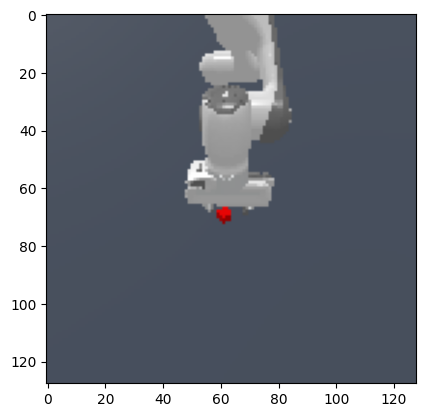

 79%|███████▉  | 790/999 [02:03<00:32,  6.40it/s]


KeyboardInterrupt: 

In [22]:
import gymnasium as gym
env = gym.make("PickCube-v0", camera_cfgs={"add_segmentation": True}, **env_info["env_kwargs"])

obs, _ = env.reset()

for e in tqdm(range(len(episodes))):
    eps = episodes[e]
    trajectory = data[f"traj_{eps['episode_id']}"]
    trajectory = load_h5_data(trajectory)

    env_state = trajectory["env_states"][0]
    env.set_state(env_state)
    actions = trajectory['actions']


# for i in tqdm(range(actions.shape[0])):
    obs, reward, terminated, truncated, info = env.step(actions[0])
    clear_output(wait=True)
    plt.imshow(obs["image"]["base_camera"]['rgb'])
    # plt.imshow(env.unwrapped.render_rgb_array())
    plt.show()


## 2) Psuedocode for Data Collection

In [3]:
"""
# Psuedocode and parameters when collecting data

# approximate data count / parameters:
    # 15 rigid body + 6 rigid body task * 81
        # task specific counterfactual:
            # pick cube: multiple cubes / objects (n = 4), 10 each
    # scene offset
        # find out X, Y, Z boundaries
        # about 10 different locations preset.
    # camera positions chained. * No more((6 + 8) * 6! camera positions)
        # let's ignore this for now. it's too confusing
        # n = 1~6.
        # about 6+8 variations

    # 21 tasks * 80 trajectories * (4 objects * 10 rand config) counterfactual objects 
    #   * 10 locations
        = 672000
    

    # output:
        # initial image, segmentation mask
        # chained prompts
        # task
        # target object name, color

        # final image, segmentation mask

    # def scene_offset():
        # need to know scene boundaries
        # return random offset

    # def run_specific trajectory(trajectory_name):
        # load the correct scene, objects
            # tested environments so far:
                1) PickCubeEnv
    
    # def chain_random_poses(n=1~4):
        # camera positions, what prompts to chain. ex: 'left(d=30) then right(d=10)', 'look up(a=30)'
            # next stage, augment the pipeline to say "look up, and then left(d=20), and then pick up cube"
            # next stage, augment the pipeline to say "go left a little bit, pick up the cube, and then right a little less, and then look up 30 degrees"
        # return {left: (distance, 30), right: (distance, 10), up: (angle, 30)}
    

    # def add_counterfactual_objects(env, n=4, grasp_t=T):
        # make sure it doesn't run into the object
        for i in range(n):
            env.unwrapped.add_object(rand_positions, rand_colors)
            env.unwrapped._build_cube(rand_positions, rand_colors)

            # make sure rand color is not the same as original color.

            # maybe some changes around where it is set.

        return env

    # def check_no_interferene(env, task):
        # to add random counterfactual objects, we can make sure it doesn't interfere with the action
        obs, _ = env.reset()
        add_counterfactual_objects(env, n=4)
        for t in range(actions.shape[0]):
            obs, reward, terminated, truncated, info = env.step(actions[t])
            if env.agent.check_grasp(env.obj, max_angle=30):
                grasp_t = t
                break

        # run again
        for t in range(actions.shape[0]):
            obs, reward, terminated, truncated, info = env.step(actions[t])
            if t == grasp_t:
                if env.agent.check_grasp(env.obj, max_angle=30): # success
                    # append the states
                else:
                    print("interference")
                    # run counterfactual objects again
                    break
"""
None

# 3) Default custom scene

In [6]:
# np.random.seed(2)


# poses = [[look_at([i, j, 0.5], [1, 1, 0]) for i, j in zip(np.random.random(size=3)*3, np.random.random(size=3) * 3)][0]]

# default camera pose
# pose = look_at([0.3, 0, 0.6], [-0.1, 0, 0.1])
camera_poses = [look_at([1.2, 0.5, 0.5], [0, 0, 0])]
offset_pose = Pose(-np.array([-0.5616, -2.1837, 0]))
rotation_pose = Pose(q=euler2quat(0, 0, -np.pi/4)) # 90

env = load_pickcube_v1(camera_poses, offset_pose, rotation_pose, env_info)

obs, _ = env.reset()
env_state = trajectory["env_states"][0]
env.set_state(env_state)
actions = trajectory['actions']

for i in tqdm(range(actions.shape[0])):
    obs, reward, terminated, truncated, info = env.step(actions[i])

    clear_output(wait=True)
    plt.imshow(obs["image"]["base_camera"]['rgb'])
    # plt.imshow(env.unwrapped.render_rgb_array())
    # break

    plt.show()
    # break


 33%|███▎      | 29/88 [00:04<00:10,  5.81it/s]


KeyboardInterrupt: 

# 4) Random Camera Angles

In [6]:
import math
import random

def calculate_distance(p1, p2):
    return math.sqrt(sum((p1_i - p2_i) ** 2 for p1_i, p2_i in zip(p1, p2)))

def fibonacci_sphere(samples=1, randomize=False, noise_std=1):
    points = []
    phi = math.pi * (3. - math.sqrt(5.))  # Golden angle in radians
    random_phase = random.uniform(0, 2 * math.pi) if randomize else 0  # Random phase if randomization is enabled

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # Radius at y
        noise = -np.abs(random.gauss(0, noise_std))
        radius_with_noise = max(0, radius + noise)


        theta = phi * i + random_phase  # Golden angle increment with optional random phase

        x = math.cos(theta) * radius_with_noise
        z = math.sin(theta) * radius_with_noise

        points.append((x, y, z))

    return points

def get_sphere_poses(n=9, randomize=False):
    default_position = [0.3, 0, 0.6]
    default_target = [-0.1, 0, 0.1]
    
    distance = calculate_distance(default_position, default_target)

    # Get n points on a Fibonacci sphere, with optional randomization
    points = fibonacci_sphere(n, randomize=randomize)

    poses = []
    for x, y, z in points:
        # Scale the point by the distance
        scaled_point = [distance * coord for coord in [x, y, z]]

        # Translate the point so it's centered around the default_target
        new_position = [default_target[j] + s¡caled_point[j] for j in range(3)]

        # Ensure the z-coordinate is greater than 0.2
        if new_position[2] < 0.2:
            new_position[2] = 0.2

        poses.append(look_at(new_position, default_target))  # Assuming look_at function generates this tuple

    return poses


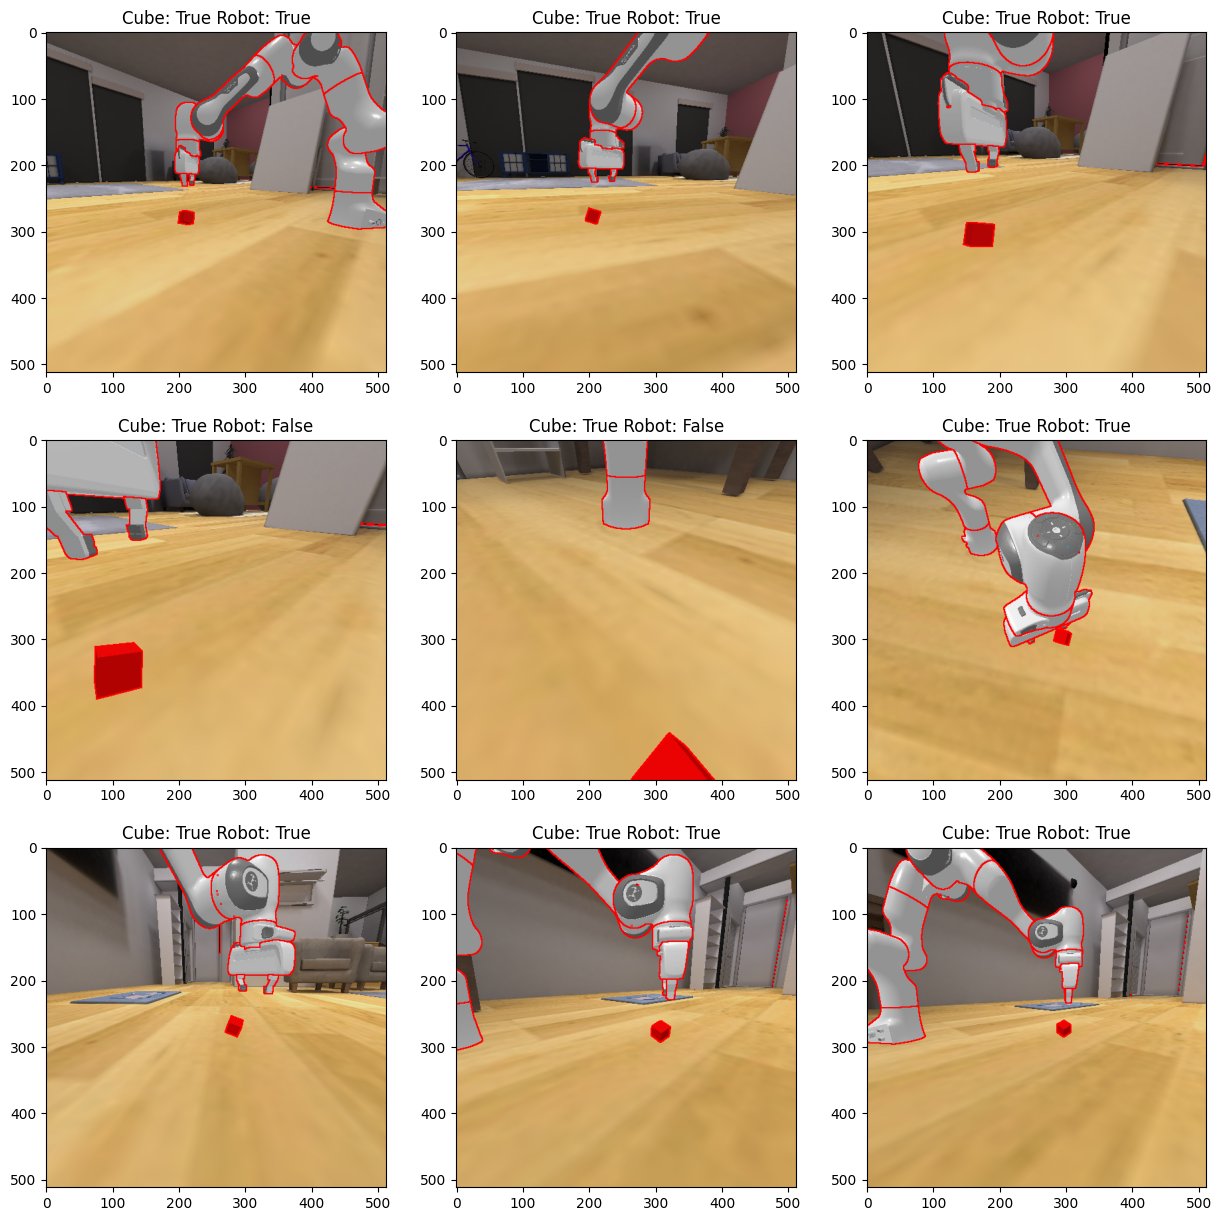

  0%|          | 0/88 [00:01<?, ?it/s]


In [7]:
# Example usage
n = 9  # Number of poses to generate
camera_poses = get_sphere_poses(n, randomize=True)

offset_pose = Pose(-np.array([-0.5616, -2.1837, 0]))
rotation_pose = Pose(q=euler2quat(0, 0, -np.pi/4)) # 90

env = load_pickcube_v1(camera_poses, offset_pose, rotation_pose, env_info)


obs, _ = env.reset()
env_state = trajectory["env_states"][0]
env.set_state(env_state)
actions = trajectory['actions']


for i in tqdm(range(actions.shape[0])):
    obs, reward, terminated, truncated, info = env.step(actions[i])

    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    clear_output(wait=True)

    for c in range(len(camera_poses)):
        rgb_img = obs["image"][f"camera_{c}"]['rgb']
        seg_img = obs["image"][f"camera_{c}"]['Segmentation'][:, :, :3]
        
        # for overlaying segmentation mask
        seg_img_normalized = seg_img / seg_img.max()
        seg_img_gray = color.rgb2gray(seg_img_normalized)
        edges = filters.sobel(seg_img_gray)
        overlay_img = rgb_img.copy()
        overlay_img[edges > np.mean(edges)] = [255, 0, 0]
        
        axs.flatten()[c].imshow(overlay_img)
        cube_present = np.any(seg_img == 13)
        robot_arm_present = np.mean([np.any(seg_img == a) for a in range(1, 12)]) > 0.5

        # env.get_actors()
        # [Actor(name="", id="14"),
        #  Actor(name="cube", id="15"),
        #  Actor(name="goal_site", id="16")]

        # segs[segs == 12] = 0 # ground = 14 - 2
        # segs[segs == 14] = 0 # goal_site = 16 - 2
        # segs[segs != 13] = 0 # cube = 15 - 2

        axs.flatten()[c].set_title(f"Cube: {cube_present} Robot: {robot_arm_present}")

    plt.show()
    break

# 5) Load random X, Y positions

In [8]:
import itertools
poses = np.array([
    [[0, 0, 0], [0, 0, 0]],
    [[-1, -1, 0], [0, 0, np.pi/2]],
    [[-1, -2, 0], [0, 0, np.pi]],
    [[-2, -2, 0], [0, 0, 3*np.pi/2]]])
poses = np.array([
    [[0, 0, 0], [0, 0, 0]],
    [[0, -1, 0], [0, 0, 0]],
    [[0, -2, 0], [0, 0, 0]],
    [[0, -3, 0], [0, 0, 0]],
    [[-1, 0, 0], [0, 0, 0]],
    [[-2, 0, 0], [0, 0, 0]],
    [[-3, 0, 0], [0, 0, 0]],
    [[-2, -2, 0], [0, 0, 0]],
    [[-3, -3, 0], [0, 0, 0]]],
    )

# Angles to choose from
angles = np.array([np.pi/2, np.pi/4, 3*np.pi/2])

# Randomize the last element of the second sub-array for each pose
for pose in poses:
    pose[1][-1] = np.random.choice(angles)

# 

In [57]:
# 9 preset config

random_numbers = np.random.randint(-1.5, 1.5, size=(n, 2))
zeros = np.zeros((n, 1))
random_positions = np.hstack((random_numbers, zeros))

random_radians = np.random.uniform(0, 2 * np.pi, size=n)
random_rotations = np.zeros((n, 3))
random_rotations[:, 2] = random_radians

n = 9
camera_poses = get_sphere_poses(n, randomize=True)

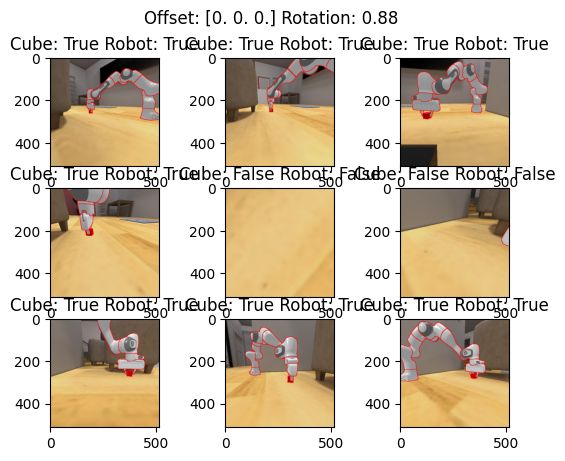

100%|██████████| 88/88 [01:37<00:00,  1.11s/it]


In [15]:
# fig, axs = plt.subplots(3, 3)
# for p in range(len(random_positions)):
# load poses
offset, rotation = random_positions[p], random_rotations[p]
offset_pose = Pose(-offset)
rotation_pose = Pose(q=euler2quat(*rotation)) # 90

# load env
env = load_pickcube_v1(camera_poses, offset_pose, rotation_pose, env_info)
obs, _ = env.reset()
env_state = trajectory["env_states"][0]
env.unwrapped.set_state(env_state)


for i in tqdm(range(actions.shape[0])):
    obs, reward, terminated, truncated, info = env.step(actions[i])

    # plot result
    fig, axs = plt.subplots(3, 3)
    clear_output(wait=True)
    for c in range(len(camera_poses)):
        rgb_img = obs["image"][f"camera_{c}"]['rgb']
        seg_img = obs["image"][f"camera_{c}"]['Segmentation'][:, :, :3]
        
        # for overlaying segmentation mask
        seg_img_normalized = seg_img / seg_img.max()
        seg_img_gray = color.rgb2gray(seg_img_normalized)
        edges = filters.sobel(seg_img_gray)
        overlay_img = rgb_img.copy()
        overlay_img[edges > np.mean(edges)] = [255, 0, 0]
        
        axs.flatten()[c].imshow(overlay_img)
        cube_present = np.any(seg_img == 13)
        robot_arm_present = np.mean([np.any(seg_img == a) for a in range(1, 12)]) > 0.5
        axs.flatten()[c].set_title(f"Cube: {cube_present} Robot: {robot_arm_present}")

    plt.suptitle(f"Offset: {offset} Rotation: {rotation[-1]:.2f}")
    plt.show()

    # axs.flatten()[p].imshow(obs["image"][f"base_camera"]['rgb'])
    # axs.flatten()[p].set_title(f"Offset: {offset} Rotation: {rotation[-1]:.2f}")
# plt.show()

# 6) Counterfactual Objects

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Register ManiSkill2 environments in gym
import mani_skill2.envs

# from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.sensors.camera import CameraConfig
from mani_skill2.utils.registration import register_env
from mani_skill2.utils.sapien_utils import look_at

from mani_skill2 import ASSET_DIR
from collections import OrderedDict
import gymnasium as gym

import numpy as np
# import sapien.core as sapien
from sapien.core import Pose
from transforms3d.euler import euler2quat

from mani_skill2.utils.registration import register_env
from mani_skill2.utils.sapien_utils import vectorize_pose
from mani_skill2.envs.pick_and_place.base_env import StationaryManipulationEnv
import warnings

poses = camera_poses
IMG_WIDTH=512
IMG_HEIGHT=512

@register_env("PickCube-v1", max_episode_steps=200, override=True)
class PickCubeEnv(StationaryManipulationEnv):
    goal_thresh = 0.025
    min_goal_dist = 0.05

    def __init__(self, *args, obj_init_rot_z=True, **kwargs):
        self.obj_init_rot_z = obj_init_rot_z
        self.cube_half_size = np.array([0.02] * 3, np.float32)
        super().__init__(*args, **kwargs)

    def _load_actors(self):
        # -------------------------------------------------------------------------- #
        # Load static scene
        # -------------------------------------------------------------------------- #

        builder = self._scene.create_actor_builder()
        path = f"{ASSET_DIR}/hab2_bench_assets/stages/Baked_sc1_staging_00.glb"
        pose = Pose(q=[0.707, 0.707, 0, 0])  # y-axis up for Habitat scenes
        # rotation_pose = sapien.Pose(q=euler2quat(0, 0, -np.pi/2)) # 90
        # pose = pose * rotation_pose
        
        # NOTE: use nonconvex collision for static scene
        builder.add_nonconvex_collision_from_file(path, pose)
        builder.add_visual_from_file(path, pose)
        self.arena = builder.build_static()
        # Add offset so that the workspace is on the table
        # offset = sapien.Pose(-np.array([-2.0616, -3.1837, 0.66467 + 0.095]))

        offset = rotation_pose * offset_pose
        self.arena.set_pose(offset)

        # self._add_ground(render=self.bg_name is None)
        self.obj = self._build_cube(self.cube_half_size)
        # self.obj2 = self._build_cube(self.cube_half_size)
        self.goal_site = self._build_sphere_site(self.goal_thresh)


    def _initialize_actors(self):
        xy = self._episode_rng.uniform(-0.1, 0.1, [2])
        xyz = np.hstack([xy, self.cube_half_size[2]])
        q = [1, 0, 0, 0]
        if self.obj_init_rot_z:
            ori = self._episode_rng.uniform(0, 2 * np.pi)
            q = euler2quat(0, 0, ori)
        self.obj.set_pose(Pose(xyz, q))

    def _initialize_task(self, max_trials=100, verbose=False):
        obj_pos = self.obj.pose.p

        # Sample a goal position far enough from the object
        for i in range(max_trials):
            goal_xy = self._episode_rng.uniform(-0.1, 0.1, [2])
            goal_z = self._episode_rng.uniform(0, 0.5) + obj_pos[2]
            goal_pos = np.hstack([goal_xy, goal_z])
            if np.linalg.norm(goal_pos - obj_pos) > self.min_goal_dist:
                if verbose:
                    print(f"Found a valid goal at {i}-th trial")
                break

        self.goal_pos = goal_pos
        self.goal_site.set_pose(Pose(self.goal_pos))

    def _get_obs_extra(self) -> OrderedDict:
        obs = OrderedDict(
            tcp_pose=vectorize_pose(self.tcp.pose),
            goal_pos=self.goal_pos,
        )
        if self._obs_mode in ["state", "state_dict"]:
            obs.update(
                tcp_to_goal_pos=self.goal_pos - self.tcp.pose.p,
                obj_pose=vectorize_pose(self.obj.pose),
                tcp_to_obj_pos=self.obj.pose.p - self.tcp.pose.p,
                obj_to_goal_pos=self.goal_pos - self.obj.pose.p,
            )
        return obs

    def _register_cameras(self):
        cameras = []
        pose = look_at([0.3, 0, 0.6], [-0.1, 0, 0.1])
        cameras.append(CameraConfig(
            "base_camera", pose.p, pose.q, IMG_WIDTH, IMG_HEIGHT, np.pi / 2, 0.01, 10
        ))

        for i in range(len(poses)):
            scene_camera = CameraConfig(
                f"camera_{i}", poses[i].p, poses[i].q, IMG_WIDTH, IMG_HEIGHT, np.pi / 2, 0.01, 10
            )
            cameras.append(scene_camera)
        return cameras

    def check_obj_placed(self):
        return np.linalg.norm(self.goal_pos - self.obj.pose.p) <= self.goal_thresh

    def check_robot_static(self, thresh=0.2):
        # Assume that the last two DoF is gripper
        qvel = self.agent.robot.get_qvel()[:-2]
        return np.max(np.abs(qvel)) <= thresh

    def evaluate(self, **kwargs):
        is_obj_placed = self.check_obj_placed()
        is_robot_static = self.check_robot_static()
        return dict(
            is_obj_placed=is_obj_placed,
            is_robot_static=is_robot_static,
            success=is_obj_placed and is_robot_static,
        )

    def compute_dense_reward(self, info, **kwargs):
        reward = 0.0

        if info["success"]:
            reward += 5
            return reward

        tcp_to_obj_pos = self.obj.pose.p - self.tcp.pose.p
        tcp_to_obj_dist = np.linalg.norm(tcp_to_obj_pos)
        reaching_reward = 1 - np.tanh(5 * tcp_to_obj_dist)
        reward += reaching_reward

        is_grasped = self.agent.check_grasp(self.obj, max_angle=30)
        reward += 1 if is_grasped else 0.0

        if is_grasped:
            obj_to_goal_dist = np.linalg.norm(self.goal_pos - self.obj.pose.p)
            place_reward = 1 - np.tanh(5 * obj_to_goal_dist)
            reward += place_reward

        return reward

    def compute_normalized_dense_reward(self, **kwargs):
        return self.compute_dense_reward(**kwargs) / 5.0

    def render_human(self):
        self.goal_site.unhide_visual()
        ret = super().render_human()
        self.goal_site.hide_visual()
        return ret

    def render_rgb_array(self):
        self.goal_site.unhide_visual()
        ret = super().render_rgb_array()
        self.goal_site.hide_visual()
        return ret

    def get_state(self) -> np.ndarray:
        state = super().get_state()
        return np.hstack([state, self.goal_pos])

    def set_state(self, state):
        self.goal_pos = state[-3:]
        super().set_state(state[:-3])

    def initialize_episode(self):
        super().initialize_episode()

        # Rotate the robot for better visualization
        self.agent.robot.set_pose(
            Pose([0, -0.56, 0], [0.707, 0, 0, 0.707])
        )

2024-03-01 17:00:39,576 - mani_skill2 - WARNING - Override registered env PickCube-v1


In [88]:
env = gym.make("PickCube-v1", camera_cfgs={"add_segmentation": True}, **env_info["env_kwargs"])


def add_random_cubes(env, n=4, offset_value = 0.2):
    # create n number of cubes with noise in its position
    for i in range(n):
        rand_color = lambda: (np.random.random(), np.random.random(), np.random.random())
        rand_offset = np.random.uniform(-1, 1, size=3) * offset_value
        rand_offset[-1] = 0

        setattr(env, f"obj{i+1}", env.unwrapped._build_cube(env.cube_half_size, color=rand_color(), static=False))
        getattr(env, f"obj{i+1}").set_pose(Pose(env.obj.get_pose().p + rand_offset, env.obj.get_pose().q))
    
# env.obj2 = env.unwrapped._build_cube(env.cube_half_size, color=(0, 1, 0), static=False)
# env.obj2.set_pose(Pose(env.obj.get_pose().p + np.array([0.1, 0.1, 0]), env.obj.get_pose().q))

obs, _ = env.reset()
env_state = trajectory["env_states"][0]
env.unwrapped.set_state(env_state)

add_random_cubes(env)

[2024-03-01 17:08:00.410] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.cube_half_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.cube_half_size` for environment variables or `env.get_wrapper_attr('cube_half_size')` that will search the reminding wrappers.
  logger.warn(
/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.obj to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.obj` for environment variables or `env.get_wrapper_attr('obj')` that will search the reminding wrappers.
  logger.warn(


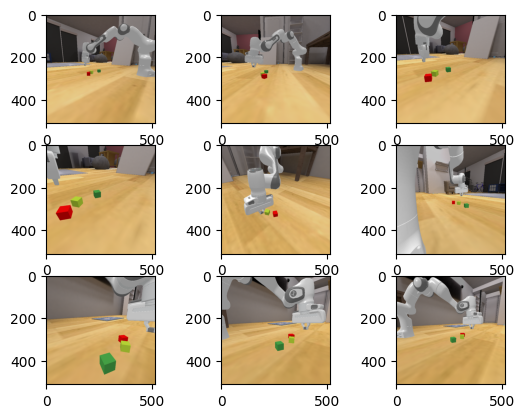

100%|██████████| 88/88 [01:03<00:00,  1.38it/s]


In [87]:
for i in tqdm(range(actions.shape[0])):
    fig, axs = plt.subplots(3, 3)
    obs, reward, terminated, truncated, info = env.step(actions[i])
    clear_output(wait=True)

    for c in range(len(camera_poses)):
        axs.flatten()[c].imshow(obs["image"][f"camera_{c}"]['rgb'])
    plt.show()

## 7) Different trajectories / tasks

In [56]:
import numpy as np
from skimage.metrics import structural_similarity

def ssim_loss(y_true, y_pred):
  """
  Calculates the SSIM loss between two images.

  Args:
    y_true: Ground truth image.
    y_pred: Predicted image.

  Returns:
    SSIM loss.
  """

  # Convert images to grayscale.
  y_true = np.mean(y_true, axis=-1)
  y_pred = np.mean(y_pred, axis=-1)

  # Calculate SSIM loss.
  loss = 1 - structural_similarity(y_true, y_pred, data_range=y_true.max() - y_true.min())

  return loss


In [66]:
ssim_loss(img_0, img_0*0.5)

0.23430686693113634